## <b style="color:Green;">Graph Creation</b>
used to create a graph data structure for the selected nodes

### <b> Importing Libraries </b>

In [2]:
import pickle
import pandas as pd
import torch

In [135]:
user_data=pd.read_csv("data/musae_git_target.csv")
selected_nodes=pickle.load(open("data/selected_nodes.pkl","rb"))
edge_data=pd.read_csv("data/musae_git_edges.csv")

### <b> Graph Gen Logic 1 </b>

* lets take 1000 developers , that is 1000 graphs with 10 nodes 
* logic : Get the first level of connection for a node if not suffient no. of nodes acquired then go for the second level
* then we'll train the network based on it

In [142]:
edge_index=[[],[]]
nodes_parsed=[]
def generate_graph(dev_id,nodes_needed):
    neighbour_dev_ids=edge_data.loc[edge_data["id_1"]==dev_id]["id_2"].values
    for neighbour_dev in neighbour_dev_ids:
        if len(set([item for sublist in edge_index for item in sublist]))>=10:
            break
        else:
            edge_index[0].append(dev_id),edge_index[1].append(neighbour_dev)
    nodes_parsed.append(dev_id)
    nodes=set([item for sublist in edge_index for item in sublist])
    if len(nodes)>=nodes_needed:
        return edge_index
    else:
        dev_id = list(set(nodes) - set(nodes_parsed))[0]
        nodes_needed-=len(neighbour_dev_ids)+1 #why plus 1 because of the current node 
        return generate_graph(dev_id,nodes_needed)
result=generate_graph(3,10)
print(result)
nodes=set([item for sublist in result for item in sublist])
len(nodes)

[[3, 3, 3, 3, 3, 18029, 18029], [4950, 18029, 3358, 34935, 5916, 36620, 25839]]


8

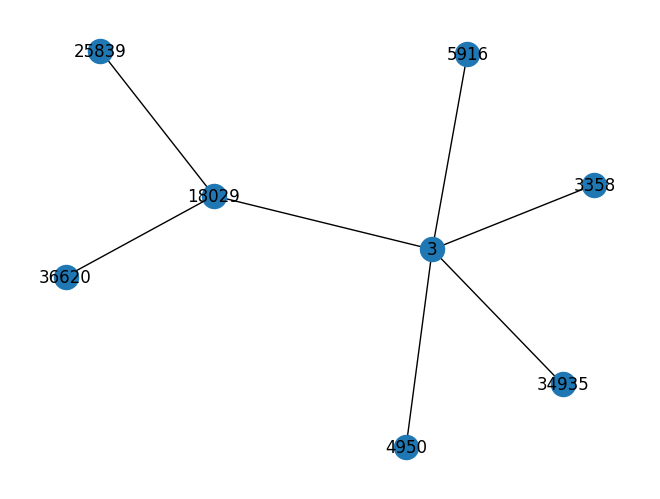

In [143]:
import networkx as nx
import matplotlib.pyplot as plt
Graph=nx.Graph()
for source,dest in zip(result[0],result[1]):
    Graph.add_edge(source,dest)
nx.draw(Graph,cmap=plt.get_cmap('viridis'),with_labels=True)

### <b> Making a dataset </b>

In [40]:
import torch
from torch_geometric.data import Data, DataLoader

# Define a simple PyTorch Geometric dataset with 4 graphs, each having 3 nodes
graph1 = Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]).long(), y=torch.tensor([0, 1, 0]))
graph2 = Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]).long(), y=torch.tensor([1, 0, 1]))
graph3 = Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]).long(), y=torch.tensor([0, 1, 1]))
graph4 = Data(x=torch.randn(3, 2), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]).long(), y=torch.tensor([1, 0, 0]))

# Create a list of graphs to form the dataset
dataset = [graph1, graph2, graph3, graph4]

# Create a PyTorch Geometric DataLoader
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Iterate over batches
for batch in loader:
    print("Batch:")
    print("Number of graphs in the batch:", batch.num_graphs)
    print("Node features shape:", batch.x.shape)
    print("Edge indices shape:", batch.edge_index.shape)
    print("Node labels shape:", batch.y.shape)
    print()


[21351, 24444, 15808, 13411, 13893]